# Distributed DeepRacer RL training with SageMaker and RoboMaker

---
## Introduction


In this notebook, we will train a fully autonomous 1/18th scale race car using reinforcement learning using Amazon SageMaker RL and AWS RoboMaker's 3D driving simulator. [AWS RoboMaker](https://console.aws.amazon.com/robomaker/home#welcome) is a service that makes it easy for developers to develop, test, and deploy robotics applications.  

This notebook provides a jailbreak experience of [AWS DeepRacer](https://console.aws.amazon.com/deepracer/home#welcome), giving us more control over the training/simulation process and RL algorithm tuning.

![Training in Action](./DeepRacerCar.png)


---
## How it works?  

![How training works](./training.png)

The reinforcement learning agent (i.e. our autonomous car) learns to drive by interacting with its environment, e.g., the track, by taking an action in a given state to maximize the expected reward. The agent learns the optimal plan of actions in training by trial-and-error through repeated episodes.  
  
The figure above shows an example of distributed RL training across SageMaker and two RoboMaker simulation envrionments that perform the **rollouts** - execute a fixed number of episodes using the current model or policy. The rollouts collect agent experiences (state-transition tuples) and share this data with SageMaker for training. SageMaker updates the model policy which is then used to execute the next sequence of rollouts. This training loop continues until the model converges, i.e. the car learns to drive and stops going off-track. More formally, we can define the problem in terms of the following:  

1. **Objective**: Learn to drive autonomously by staying close to the center of the track.
2. **Environment**: A 3D driving simulator hosted on AWS RoboMaker.
3. **State**: The driving POV image captured by the car's head camera, as shown in the illustration above.
4. **Action**: Six discrete steering wheel positions at different angles (configurable)
5. **Reward**: Positive reward for staying close to the center line; High penalty for going off-track. This is configurable and can be made more complex (for e.g. steering penalty can be added).

## Prequisites

### Imports

To get started, we'll import the Python libraries we need, set up the environment with a few prerequisites for permissions and configurations.

You can run this notebook from your local machine or from a SageMaker notebook instance. In both of these scenarios, you can run the following to launch a training job on SageMaker and a simulation job on RoboMaker.

In [1]:
import boto3
import sagemaker
import sys
import os
import re
import numpy as np
import subprocess
import yaml

sys.path.append("common")
sys.path.append("./src")
from misc import get_execution_role, wait_for_s3_object
from docker_utils import build_and_push_docker_image
from docker_utils import push as docker_push
from sagemaker.rl import RLEstimator, RLToolkit, RLFramework
from time import gmtime, strftime
import time
from IPython.display import Markdown
from markdown_helper import *

### Create an IAM role
Either get the execution role when running from a SageMaker notebook `role = sagemaker.get_execution_role()` or, when running from local machine, use utils method `role = get_execution_role('role_name')` to create an execution role.

In [2]:
try:
    sagemaker_role = sagemaker.get_execution_role()
except:
    sagemaker_role = get_execution_role("sagemaker")

print("Using Sagemaker IAM role arn: \n{}".format(sagemaker_role))

Using Sagemaker IAM role arn: 
arn:aws:iam::687392285187:role/service-role/AmazonSageMaker-ExecutionRole-20190701T155040


> Please note that this notebook cannot be run in `SageMaker local mode` as the simulator is based on AWS RoboMaker service.

### Permission setup for invoking AWS RoboMaker from this notebook
In order to enable this notebook to be able to execute AWS RoboMaker jobs, we need to add one trust relationship to the default execution role of this notebook.

In [3]:
display(Markdown(generate_help_for_robomaker_trust_relationship(sagemaker_role)))

1. Go to IAM console to edit current SageMaker role: [AmazonSageMaker-ExecutionRole-20190701T155040](https://console.aws.amazon.com/iam/home#/roles/AmazonSageMaker-ExecutionRole-20190701T155040).
2. Next, go to the `Trust relationships tab` and click on `Edit Trust Relationship.` 
3. Replace the JSON blob with the following:
```json
            {
              "Version": "2012-10-17",
              "Statement": [
                {
                  "Effect": "Allow",
                  "Principal": {
                    "Service": [
                      "sagemaker.amazonaws.com",
                      "robomaker.amazonaws.com"
                    ]
                  },
                  "Action": "sts:AssumeRole"
                }
              ]
            }```
4. Once this is complete, click on Update Trust Policy and you are done.

### Permission setup for Sagemaker to S3 bucket

The sagemaker writes the Redis IP address, models to the S3 bucket. This requires PutObject permission on the bucket. Make sure the sagemaker role you are using as this permissions.

In [4]:
display(Markdown(generate_s3_write_permission_for_sagemaker_role(sagemaker_role)))

1. Go to IAM console to edit current SageMaker role: [AmazonSageMaker-ExecutionRole-20190701T155040](https://console.aws.amazon.com/iam/home#/roles/AmazonSageMaker-ExecutionRole-20190701T155040).
2. Next, go to the `Permissions tab` and click on `Attach Policy.` 
3. Search and select `AmazonKinesisVideoStreamsFullAccess` policy


### Permission setup for Sagemaker to create KinesisVideoStreams

The sagemaker notebook has to create a kinesis video streamer. You can observer the car making epsiodes in the kinesis video streamer.

In [5]:
display(Markdown(generate_kinesis_create_permission_for_sagemaker_role(sagemaker_role)))

1. Go to IAM console to edit current SageMaker role: [AmazonSageMaker-ExecutionRole-20190701T155040](https://console.aws.amazon.com/iam/home#/roles/AmazonSageMaker-ExecutionRole-20190701T155040).
2. Next, go to the `Permissions tab` and click on `Attach Policy.` 
3. Search and select `AmazonS3FullAccess` policy


### Permission setup for Sagemaker to pull Docker image

The sagemaker notebook has to pull the simulation docker image.

In [6]:
display(Markdown(generate_ecr_read_create_permission_for_sagemaker_role(sagemaker_role)))

1. Go to IAM console to edit current SageMaker role: [AmazonSageMaker-ExecutionRole-20190701T155040](https://console.aws.amazon.com/iam/home#/roles/AmazonSageMaker-ExecutionRole-20190701T155040).
2. Next, go to the `Permissions tab` and click on `Attach Policy.` 
3. Search and select `AmazonElasticContainerRegistryPublicReadOnly` policy


### Permission setup for Sagemaker to push Docker image to your account ECR

The sagemaker notebook has to push the pulled public ECR/edited local ECR to your account ECR

In [7]:
display(Markdown(generate_ecr_push_local_docker_image_for_sagemaker_role(sagemaker_role)))

1. Go to IAM console to edit current SageMaker role: [AmazonSageMaker-ExecutionRole-20190701T155040](https://console.aws.amazon.com/iam/home#/roles/AmazonSageMaker-ExecutionRole-20190701T155040).
2. Next, go to the `Permissions tab` and click on `Attach Policy.` 
3. Search and select `EC2InstanceProfileForImageBuilderECRContainerBuilds` policy


## Get latest markov package from the simapp image to run on SageMaker instance

In [8]:
# This is the name of the simapp that is locally created and pushed to your account ECR
local_simapp_ecr_docker_image_name = "deepracer-sim-local-notebook"
public_ecr_alias = "k1d3r4z1"

# Clean up the docker images
!docker rm -f $(docker ps -a -q);
!docker rmi -f $(docker images -q);

!aws ecr-public get-login-password --region us-east-1 | docker login --username AWS --password-stdin public.ecr.aws

!docker pull public.ecr.aws/{public_ecr_alias}/deepracer-sim-public

!docker tag public.ecr.aws/{public_ecr_alias}/deepracer-sim-public {local_simapp_ecr_docker_image_name}

# Get docker id and container id
simapp_docker_ids = !docker images | grep deepracer-sim-public | tr -s ' '| cut -d ' ' -f 3 | head -n 1
simapp_docker_id = simapp_docker_ids[0]
simapp_container_ids = !docker run -d -t {simapp_docker_id}
simapp_container_id = simapp_container_ids[0]

# Copy all the required training related code and update the code base
!docker cp {simapp_container_id}:/opt/amazon/markov ./src/
!docker cp {simapp_container_id}:/opt/amazon/rl_coach.patch ./src/
!docker cp {simapp_container_id}:/opt/ml/code/. ./src/lib/

# Push the docker image to your ECR account 
docker_push(local_simapp_ecr_docker_image_name)

27a592512a37
Untagged: 687392285187.dkr.ecr.us-east-1.amazonaws.com/sagemaker-docker-cpu:latest
Untagged: 687392285187.dkr.ecr.us-east-1.amazonaws.com/sagemaker-docker-cpu@sha256:4fd55eecefe5c7910fee8e5e6d471aa82fda9eb9b5e5aa2f327df28bf7a62950
Untagged: sagemaker-docker-cpu:latest
Deleted: sha256:6cef2375ea7d9de502ae942f45cb2a5f11aadaae056a1ff5a97007979ac3a394
Deleted: sha256:605880da099aa776ddd32b75d68bc53f44736147e415413fe6f8ec4d49cb54d3
Deleted: sha256:06e539a91a56c765792979388f91dd3105dd379339caef62d9580977652618f7
Deleted: sha256:001e7523823bfd390ed0f090d89cc94ac19dcca787928e10b9187845e6cf80bb
Deleted: sha256:df0e01e9ea68a54399f295f5359d8bb591363c066588c68be62dbe026f5f382c
Deleted: sha256:946398a9ccc52b0acd72f8d3fd4118089d87f30928832e2fe4d7f8f019b4eab0
Deleted: sha256:2850be31fd2191716c61a8b857d20eaf6bad7a1525fbf45cd410999f12bf7005
Deleted: sha256:6796aeb9cc30d606d4e6799eacd7d7ab4b42c7b4faceb924e2f5807a63e80b03
Deleted: sha256:0ed3635e40a175ceb51b7bb30a687c777171ca2c5dd88d6c9bb345

ed9c51b: Extracting    342MB/560.5MBBDownloading  232.2MB/905MBDownloading    876MB/905MB

cb417dff: Extracting  481.9MB/905MBBBExtracting  30.08MB/336.8MB

Digest: sha256:60fdae00b44eaadb99cf3834f07b6c434cda87c4a3f0448fc0037d3fc23970d2
Status: Downloaded newer image for public.ecr.aws/k1d3r4z1/deepracer-sim-public:latest
public.ecr.aws/k1d3r4z1/deepracer-sim-public:latest
ECR repository already exists: deepracer-sim-local-notebook
WARNING! Using --password via the CLI is insecure. Use --password-stdin.
WARNING! Your password will be stored unencrypted in /home/ec2-user/.docker/config.json.
Configure a credential helper to remove this warning. See
https://docs.docker.com/engine/reference/commandline/login/#credentials-store

Login Succeeded
Logged into ECR
$ docker tag deepracer-sim-local-notebook 687392285187.dkr.ecr.us-east-1.amazonaws.com/deepracer-sim-local-notebook
Pushing docker image to ECR repository 687392285187.dkr.ecr.us-east-1.amazonaws.com/deepracer-sim-local-notebook

$ docker push 687392285187.dkr.ecr.us-east-1.amazonaws.com/deepracer-sim-local-notebook
Using default tag: latest
The push refers to repository [687392285187.dk

'687392285187.dkr.ecr.us-east-1.amazonaws.com/deepracer-sim-local-notebook'

### Run these command if you wish to modify the SageMaker and Robomaker code
<span style="color:red">Note: Make sure you have atleast 25 GB of space when you are planning to modify the Sagemaker and Robomaker code</span>

In [9]:
# # Get docker id and container id
# simapp_docker_ids = !docker images | grep deepracer-sim-local-notebook | tr -s ' '| cut -d ' ' -f 3 | head -n 1
# simapp_docker_id = simapp_docker_ids[0]
# simapp_container_ids = !docker run -d -t {simapp_docker_id}
# simapp_container_id = simapp_container_ids[0]

# !docker cp ./src/markov {simapp_container_id}:/opt/amazon/
# !docker cp ./src/rl_coach.patch {simapp_container_id}:/opt/amazon/
# !docker cp ./src/lib/. {simapp_container_id}:/opt/ml/code/.
    
# !docker exec {simapp_container_id} /opt/ml/code/scripts/build_deepracer_ros_packages.sh

# !docker exec {simapp_container_id} /opt/ml/code/scripts/clean_up_local.sh
# !docker commit {simapp_container_id} public.ecr.aws/w3a1b0b6/deepracer-sim-public

### Initializing basic parameters

In [10]:
# Select the instance type
instance_type = "ml.c4.2xlarge"
# instance_type = "ml.p2.xlarge"
# instance_type = "ml.c5.4xlarge"

# Starting SageMaker session
sage_session = sagemaker.session.Session()

# Create unique job name.
job_name_prefix = "deepracer-notebook"

# Duration of job in seconds (1 hours)
job_duration_in_seconds = 3600

# AWS Region
aws_region = sage_session.boto_region_name
if aws_region not in ["us-west-2", "us-east-1", "eu-west-1"]:
    raise Exception(
        "This notebook uses RoboMaker which is available only in US East (N. Virginia),"
        "US West (Oregon) and EU (Ireland). Please switch to one of these regions."
    )

### Setup S3 bucket
Set up the linkage and authentication to the S3 bucket that we want to use for checkpoint and metadata.

In [11]:
# S3 bucket
s3_bucket = sage_session.default_bucket()

# SDK appends the job name and output folder
s3_output_path = "s3://{}/".format(s3_bucket)

# Ensure that the S3 prefix contains the keyword 'sagemaker'
s3_prefix = job_name_prefix + "-sagemaker-" + strftime("%y%m%d-%H%M%S", gmtime())

# Get the AWS account id of this account
sts = boto3.client("sts")
account_id = sts.get_caller_identity()["Account"]

print("Using s3 bucket {}".format(s3_bucket))
print(
    "Model checkpoints and other metadata will be stored at: \ns3://{}/{}".format(
        s3_bucket, s3_prefix
    )
)

Using s3 bucket sagemaker-us-east-1-687392285187
Model checkpoints and other metadata will be stored at: 
s3://sagemaker-us-east-1-687392285187/deepracer-notebook-sagemaker-211112-182426


### Build and push docker image

The file ./Dockerfile contains all the packages that are installed into the docker. Instead of using the default sagemaker container. We will be using this docker container.

In [12]:
%%time
from copy_to_sagemaker_container import (
    get_sagemaker_docker,
    copy_to_sagemaker_container,
    get_custom_image_name,
)

cpu_or_gpu = "gpu" if instance_type.startswith("ml.p") else "cpu"
repository_short_name = "sagemaker-docker-%s" % cpu_or_gpu
custom_image_name = get_custom_image_name(repository_short_name)
try:
    print("Copying files from your notebook to existing sagemaker container")
    sagemaker_docker_id = get_sagemaker_docker(repository_short_name)
    copy_to_sagemaker_container(sagemaker_docker_id, repository_short_name)
except Exception as e:
    print("Creating sagemaker container")
    docker_build_args = {
        "CPU_OR_GPU": cpu_or_gpu,
        "AWS_REGION": boto3.Session().region_name,
    }
    custom_image_name = build_and_push_docker_image(
        repository_short_name, build_args=docker_build_args
    )
    print("Using ECR image %s" % custom_image_name)

Copying files from your notebook to existing sagemaker container
docker images sagemaker-docker-cpu | sed -n 2,2p
Creating sagemaker container
Building docker image sagemaker-docker-cpu from Dockerfile
$ docker build -t sagemaker-docker-cpu -f Dockerfile . --build-arg CPU_OR_GPU=cpu --build-arg AWS_REGION=us-east-1
Sending build context to Docker daemon  45.05MB
Step 1/26 : FROM ubuntu:18.04
18.04: Pulling from library/ubuntu
284055322776: Pulling fs layer
284055322776: Verifying Checksum
284055322776: Download complete
284055322776: Pull complete
Digest: sha256:0fedbd5bd9fb72089c7bbca476949e10593cebed9b1fb9edf5b79dbbacddd7d6
Status: Downloaded newer image for ubuntu:18.04
 ---> 5a214d77f5d7
Step 2/26 : COPY ./src/markov /opt/amazon/markov
 ---> e5f0c4f87983
Step 3/26 : RUN apt-get update && apt-get install -y     build-essential     cmake     git     curl     vim     ca-certificates     libjpeg-dev     wget     fonts-liberation     libxss1 libappindicator1 libindicator7     xvfb     l

The following NEW packages will be installed:
  adwaita-icon-theme binutils binutils-common binutils-x86-64-linux-gnu
  build-essential ca-certificates cmake cmake-data cpp cpp-7 curl dbus
  dh-python dirmngr distro-info-data dpkg-dev fakeroot file fontconfig
  fontconfig-config fonts-liberation g++ g++-7 gcc gcc-7 gcc-7-base
  geoip-database gir1.2-glib-2.0 git git-man gnupg gnupg-l10n gnupg-utils gpg
  gpg-agent gpg-wks-client gpg-wks-server gpgconf gpgsm gtk-update-icon-cache
  hicolor-icon-theme humanity-icon-theme iproute2 krb5-locales less
  libalgorithm-diff-perl libalgorithm-diff-xs-perl libalgorithm-merge-perl
  libapparmor1 libappindicator1 libarchive13 libasan4 libasn1-8-heimdal
  libasound2 libasound2-data libassuan0 libatk1.0-0 libatk1.0-data libatm1
  libatomic1 libauthen-sasl-perl libavahi-client3 libavahi-common-data
  libavahi-common3 libbinutils libbsd0 libc-dev-bin libc6-dev libcairo2
  libcc1-0 libcilkrts5 libcroco3 libcups2 libcurl3-gnutls libcurl4
  libdata-dump-p

Get:40 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libxml2 amd64 2.9.4+dfsg1-6.1ubuntu1.4 [664 kB]
Get:41 http://archive.ubuntu.com/ubuntu bionic/main amd64 shared-mime-info amd64 1.9-2 [426 kB]
Get:42 http://archive.ubuntu.com/ubuntu bionic/main amd64 libgdk-pixbuf2.0-common all 2.36.11-2 [4536 B]
Get:43 http://archive.ubuntu.com/ubuntu bionic/main amd64 libgdk-pixbuf2.0-0 amd64 2.36.11-2 [165 kB]
Get:44 http://archive.ubuntu.com/ubuntu bionic/main amd64 libthai-data all 0.1.27-2 [133 kB]
Get:45 http://archive.ubuntu.com/ubuntu bionic/main amd64 libdatrie1 amd64 0.2.10-7 [17.8 kB]
Get:46 http://archive.ubuntu.com/ubuntu bionic/main amd64 libthai0 amd64 0.1.27-2 [18.0 kB]
Get:47 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libpango-1.0-0 amd64 1.40.14-1ubuntu0.1 [153 kB]
Get:48 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libdbusmenu-gtk4 amd64 16.04.1+18.04.20171206-0ubuntu2 [26.9 kB]
Get:49 http://archive.ubuntu.com/ubuntu bionic/main amd64 

Get:120 http://archive.ubuntu.com/ubuntu bionic/main amd64 python3-dbus amd64 1.2.6-1 [89.9 kB]
Get:121 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 python3-gi amd64 3.26.1-2ubuntu1 [153 kB]
Get:122 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 xxd amd64 2:8.0.1453-1ubuntu1.6 [49.5 kB]
Get:123 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 vim-common all 2:8.0.1453-1ubuntu1.6 [70.6 kB]
Get:124 http://archive.ubuntu.com/ubuntu bionic/main amd64 xdg-user-dirs amd64 0.17-1ubuntu1 [48.0 kB]
Get:125 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 xkb-data all 2.23.1-1ubuntu1.18.04.1 [325 kB]
Get:126 http://archive.ubuntu.com/ubuntu bionic/main amd64 xz-utils amd64 5.2.2-1.3 [83.8 kB]
Get:127 http://archive.ubuntu.com/ubuntu bionic/main amd64 geoip-database all 20180315-1 [2090 kB]
Get:128 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 krb5-locales all 1.16-2ubuntu0.2 [13.4 kB]
Get:129 http://archive.ubuntu.com/ubuntu bionic-updat

Get:198 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 curl amd64 7.58.0-2ubuntu3.16 [159 kB]
Get:199 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 python3-lib2to3 all 3.6.9-1~18.04 [77.4 kB]
Get:200 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 python3-distutils all 3.6.9-1~18.04 [144 kB]
Get:201 http://archive.ubuntu.com/ubuntu bionic/main amd64 dh-python all 3.20180325ubuntu2 [89.2 kB]
Get:202 http://archive.ubuntu.com/ubuntu bionic/main amd64 libassuan0 amd64 2.5.1-2 [35.0 kB]
Get:203 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 gpgconf amd64 2.2.4-1ubuntu1.4 [123 kB]
Get:204 http://archive.ubuntu.com/ubuntu bionic/main amd64 libksba8 amd64 1.3.5-2 [92.6 kB]
Get:205 http://archive.ubuntu.com/ubuntu bionic/main amd64 libnpth0 amd64 1.5-3 [7668 B]
Get:206 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 dirmngr amd64 2.2.4-1ubuntu1.4 [316 kB]
Get:207 http://archive.ubuntu.com/ubuntu bionic/main amd64 libfakeroot amd64 1.22

Get:294 http://archive.ubuntu.com/ubuntu bionic/main amd64 libxml-parser-perl amd64 2.44-2build3 [199 kB]
Get:295 http://archive.ubuntu.com/ubuntu bionic/main amd64 libxml-twig-perl all 1:3.50-1 [156 kB]
Get:296 http://archive.ubuntu.com/ubuntu bionic/main amd64 libnet-dbus-perl amd64 1.1.0-4build2 [176 kB]
Get:297 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 nginx-common all 1.14.0-0ubuntu1.9 [37.2 kB]
Get:298 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libnginx-mod-http-geoip amd64 1.14.0-0ubuntu1.9 [11.0 kB]
Get:299 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libnginx-mod-http-image-filter amd64 1.14.0-0ubuntu1.9 [14.3 kB]
Get:300 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libxslt1.1 amd64 1.1.29-5ubuntu0.2 [150 kB]
Get:301 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libnginx-mod-http-xslt-filter amd64 1.14.0-0ubuntu1.9 [12.7 kB]
Get:302 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libnginx-mod-

Setting up libssl1.1:amd64 (1.1.1-1ubuntu2.1~18.04.13) ...
debconf: unable to initialize frontend: Dialog
debconf: (TERM is not set, so the dialog frontend is not usable.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (Can't locate Term/ReadLine.pm in @INC (you may need to install the Term::ReadLine module) (@INC contains: /etc/perl /usr/local/lib/x86_64-linux-gnu/perl/5.26.1 /usr/local/share/perl/5.26.1 /usr/lib/x86_64-linux-gnu/perl5/5.26 /usr/share/perl5 /usr/lib/x86_64-linux-gnu/perl/5.26 /usr/share/perl/5.26 /usr/local/lib/site_perl /usr/lib/x86_64-linux-gnu/perl-base) at /usr/share/perl5/Debconf/FrontEnd/Readline.pm line 7.)
debconf: falling back to frontend: Teletype
Setting up libpython3.6-minimal:amd64 (3.6.9-1~18.04ubuntu1.4) ...
Setting up libexpat1:amd64 (2.2.5-3ubuntu0.2) ...
Setting up python3.6-minimal (3.6.9-1~18.04ubuntu1.4) ...
Selecting previously unselected package python3-minimal.
(Reading database ... 4322 fi

Selecting previously unselected package libdbusmenu-gtk4:amd64.
Preparing to unpack .../025-libdbusmenu-gtk4_16.04.1+18.04.20171206-0ubuntu2_amd64.deb ...
Unpacking libdbusmenu-gtk4:amd64 (16.04.1+18.04.20171206-0ubuntu2) ...
Selecting previously unselected package libgtk2.0-common.
Preparing to unpack .../026-libgtk2.0-common_2.24.32-1ubuntu1_all.deb ...
Unpacking libgtk2.0-common (2.24.32-1ubuntu1) ...
Selecting previously unselected package libpixman-1-0:amd64.
Preparing to unpack .../027-libpixman-1-0_0.34.0-2_amd64.deb ...
Unpacking libpixman-1-0:amd64 (0.34.0-2) ...
Selecting previously unselected package libxcb-render0:amd64.
Preparing to unpack .../028-libxcb-render0_1.13-2~ubuntu18.04_amd64.deb ...
Unpacking libxcb-render0:amd64 (1.13-2~ubuntu18.04) ...
Selecting previously unselected package libxcb-shm0:amd64.
Preparing to unpack .../029-libxcb-shm0_1.13-2~ubuntu18.04_amd64.deb ...
Unpacking libxcb-shm0:amd64 (1.13-2~ubuntu18.04) ...
Selecting previously unselected package li

Selecting previously unselected package libxxf86vm1:amd64.
Preparing to unpack .../071-libxxf86vm1_1%3a1.1.4-1_amd64.deb ...
Unpacking libxxf86vm1:amd64 (1:1.1.4-1) ...
Selecting previously unselected package perl-modules-5.26.
Preparing to unpack .../072-perl-modules-5.26_5.26.1-6ubuntu0.5_all.deb ...
Unpacking perl-modules-5.26 (5.26.1-6ubuntu0.5) ...
Selecting previously unselected package libgdbm5:amd64.
Preparing to unpack .../073-libgdbm5_1.14.1-6_amd64.deb ...
Unpacking libgdbm5:amd64 (1.14.1-6) ...
Selecting previously unselected package libgdbm-compat4:amd64.
Preparing to unpack .../074-libgdbm-compat4_1.14.1-6_amd64.deb ...
Unpacking libgdbm-compat4:amd64 (1.14.1-6) ...
Selecting previously unselected package libperl5.26:amd64.
Preparing to unpack .../075-libperl5.26_5.26.1-6ubuntu0.5_amd64.deb ...
Unpacking libperl5.26:amd64 (5.26.1-6ubuntu0.5) ...
Selecting previously unselected package perl.
Preparing to unpack .../076-perl_5.26.1-6ubuntu0.5_amd64.deb ...
Unpacking perl (5

Selecting previously unselected package binutils.
Preparing to unpack .../121-binutils_2.30-21ubuntu1~18.04.7_amd64.deb ...
Unpacking binutils (2.30-21ubuntu1~18.04.7) ...
Selecting previously unselected package libc-dev-bin.
Preparing to unpack .../122-libc-dev-bin_2.27-3ubuntu1.4_amd64.deb ...
Unpacking libc-dev-bin (2.27-3ubuntu1.4) ...
Selecting previously unselected package linux-libc-dev:amd64.
Preparing to unpack .../123-linux-libc-dev_4.15.0-162.170_amd64.deb ...
Unpacking linux-libc-dev:amd64 (4.15.0-162.170) ...
Selecting previously unselected package libc6-dev:amd64.
Preparing to unpack .../124-libc6-dev_2.27-3ubuntu1.4_amd64.deb ...
Unpacking libc6-dev:amd64 (2.27-3ubuntu1.4) ...
Selecting previously unselected package gcc-7-base:amd64.
Preparing to unpack .../125-gcc-7-base_7.5.0-3ubuntu1~18.04_amd64.deb ...
Unpacking gcc-7-base:amd64 (7.5.0-3ubuntu1~18.04) ...
Selecting previously unselected package libisl19:amd64.
Preparing to unpack .../126-libisl19_0.19-1_amd64.deb ...

Selecting previously unselected package libldap-2.4-2:amd64.
Preparing to unpack .../167-libldap-2.4-2_2.4.45+dfsg-1ubuntu1.10_amd64.deb ...
Unpacking libldap-2.4-2:amd64 (2.4.45+dfsg-1ubuntu1.10) ...
Selecting previously unselected package libnghttp2-14:amd64.
Preparing to unpack .../168-libnghttp2-14_1.30.0-1ubuntu1_amd64.deb ...
Unpacking libnghttp2-14:amd64 (1.30.0-1ubuntu1) ...
Selecting previously unselected package librtmp1:amd64.
Preparing to unpack .../169-librtmp1_2.4+20151223.gitfa8646d.1-1_amd64.deb ...
Unpacking librtmp1:amd64 (2.4+20151223.gitfa8646d.1-1) ...
Selecting previously unselected package libcurl4:amd64.
Preparing to unpack .../170-libcurl4_7.58.0-2ubuntu3.16_amd64.deb ...
Unpacking libcurl4:amd64 (7.58.0-2ubuntu3.16) ...
Selecting previously unselected package libjsoncpp1:amd64.
Preparing to unpack .../171-libjsoncpp1_1.7.4-3_amd64.deb ...
Unpacking libjsoncpp1:amd64 (1.7.4-3) ...
Selecting previously unselected package librhash0:amd64.
Preparing to unpack .../

Selecting previously unselected package libtimedate-perl.
Preparing to unpack .../217-libtimedate-perl_2.3000-2_all.deb ...
Unpacking libtimedate-perl (2.3000-2) ...
Selecting previously unselected package libhttp-date-perl.
Preparing to unpack .../218-libhttp-date-perl_6.02-1_all.deb ...
Unpacking libhttp-date-perl (6.02-1) ...
Selecting previously unselected package libfile-listing-perl.
Preparing to unpack .../219-libfile-listing-perl_6.04-1_all.deb ...
Unpacking libfile-listing-perl (6.04-1) ...
Selecting previously unselected package libfile-mimeinfo-perl.
Preparing to unpack .../220-libfile-mimeinfo-perl_0.28-1_all.deb ...
Unpacking libfile-mimeinfo-perl (0.28-1) ...
Selecting previously unselected package libfont-afm-perl.
Preparing to unpack .../221-libfont-afm-perl_1.20-2_all.deb ...
Unpacking libfont-afm-perl (1.20-2) ...
Selecting previously unselected package libfontenc1:amd64.
Preparing to unpack .../222-libfontenc1_1%3a1.1.3-1_amd64.deb ...
Unpacking libfontenc1:amd64 (1:

Preparing to unpack .../265-libtry-tiny-perl_0.30-1_all.deb ...
Unpacking libtry-tiny-perl (0.30-1) ...
Selecting previously unselected package libwww-robotrules-perl.
Preparing to unpack .../266-libwww-robotrules-perl_6.01-1_all.deb ...
Unpacking libwww-robotrules-perl (6.01-1) ...
Selecting previously unselected package libwww-perl.
Preparing to unpack .../267-libwww-perl_6.31-1ubuntu0.1_all.deb ...
Unpacking libwww-perl (6.31-1ubuntu0.1) ...
Selecting previously unselected package liblwp-protocol-https-perl.
Preparing to unpack .../268-liblwp-protocol-https-perl_6.07-2_all.deb ...
Unpacking liblwp-protocol-https-perl (6.07-2) ...
Selecting previously unselected package libnet-smtp-ssl-perl.
Preparing to unpack .../269-libnet-smtp-ssl-perl_1.04-1_all.deb ...
Unpacking libnet-smtp-ssl-perl (1.04-1) ...
Selecting previously unselected package libmailtools-perl.
Preparing to unpack .../270-libmailtools-perl_2.18-1_all.deb ...
Unpacking libmailtools-perl (2.18-1) ...
Selecting previously

Preparing to unpack .../312-python3.6-dev_3.6.9-1~18.04ubuntu1.4_amd64.deb ...
Unpacking python3.6-dev (3.6.9-1~18.04ubuntu1.4) ...
Selecting previously unselected package python3-dev.
Preparing to unpack .../313-python3-dev_3.6.7-1~18.04_amd64.deb ...
Unpacking python3-dev (3.6.7-1~18.04) ...
Selecting previously unselected package python3-secretstorage.
Preparing to unpack .../314-python3-secretstorage_2.3.1-2_all.deb ...
Unpacking python3-secretstorage (2.3.1-2) ...
Selecting previously unselected package python3-keyring.
Preparing to unpack .../315-python3-keyring_10.6.0-1_all.deb ...
Unpacking python3-keyring (10.6.0-1) ...
Selecting previously unselected package python3-keyrings.alt.
Preparing to unpack .../316-python3-keyrings.alt_3.0-1_all.deb ...
Unpacking python3-keyrings.alt (3.0-1) ...
Selecting previously unselected package python3-pip.
Preparing to unpack .../317-python3-pip_9.0.1-2.3~ubuntu1.18.04.5_all.deb ...
Unpacking python3-pip (9.0.1-2.3~ubuntu1.18.04.5) ...
Select

Setting up liblsan0:amd64 (8.4.0-1ubuntu1~18.04) ...
Setting up libcroco3:amd64 (0.6.12-2) ...
Setting up libxslt1.1:amd64 (1.1.29-5ubuntu0.2) ...
Setting up gcc-7-base:amd64 (7.5.0-3ubuntu1~18.04) ...
Setting up binutils-common:amd64 (2.30-21ubuntu1~18.04.7) ...
Setting up libatk1.0-data (2.28.1-1) ...
Setting up libmpx2:amd64 (8.4.0-1ubuntu1~18.04) ...
Setting up libx11-xcb1:amd64 (2:1.6.4-3ubuntu0.4) ...
Setting up libpixman-1-0:amd64 (0.34.0-2) ...
Setting up gir1.2-glib-2.0:amd64 (1.56.1-1) ...
Setting up patch (2.7.6-2ubuntu1.1) ...
Setting up libglib2.0-data (2.56.4-0ubuntu0.18.04.8) ...
Setting up libdbusmenu-glib4:amd64 (16.04.1+18.04.20171206-0ubuntu2) ...
Setting up krb5-locales (1.16-2ubuntu0.2) ...
Setting up libatm1:amd64 (1:2.5.1-2build1) ...
Setting up publicsuffix (20180223.1310-1) ...
Setting up libxtables12:amd64 (1.6.1-2ubuntu2) ...
Setting up libapparmor1:amd64 (2.12-4ubuntu5.1) ...
Setting up libatk1.0-0:amd64 (2.28.1-1) ...
Setting up xz-utils (5.2.2-1.3) ...
upd

Setting up libjpeg-dev:amd64 (8c-2ubuntu8) ...
Setting up libperl5.26:amd64 (5.26.1-6ubuntu0.5) ...
Setting up gpgsm (2.2.4-1ubuntu1.4) ...
Setting up gnupg-utils (2.2.4-1ubuntu1.4) ...
Setting up libice6:amd64 (2:1.0.9-2) ...
Setting up libexpat1-dev:amd64 (2.2.5-3ubuntu0.2) ...
Setting up pinentry-curses (1.1.0-1) ...
Setting up libkrb5-3:amd64 (1.16-2ubuntu0.2) ...
Setting up libavahi-common3:amd64 (0.7-3.1ubuntu1.3) ...
Setting up libdrm-radeon1:amd64 (2.4.101-2~18.04.1) ...
Setting up libkrb5-26-heimdal:amd64 (7.5.0+dfsg-1) ...
Setting up libpng-dev:amd64 (1.6.34-1ubuntu0.18.04.2) ...
Setting up dbus (1.12.2-1ubuntu1.2) ...
Setting up libdrm-nouveau2:amd64 (2.4.101-2~18.04.1) ...
Setting up libxcb1:amd64 (1.13-2~ubuntu18.04) ...
Setting up libheimntlm0-heimdal:amd64 (7.5.0+dfsg-1) ...
Setting up gpg (2.2.4-1ubuntu1.4) ...
Setting up libpython3.6:amd64 (3.6.9-1~18.04ubuntu1.4) ...
Setting up binutils-x86-64-linux-gnu (2.30-21ubuntu1~18.04.7) ...
Setting up libpython3-stdlib:amd64 (

Setting up libwww-robotrules-perl (6.01-1) ...
Setting up python3-distutils (3.6.9-1~18.04) ...
Setting up libauthen-sasl-perl (2.1600-1) ...
Setting up xfonts-base (1:1.0.4+nmu1) ...
Setting up fontconfig (2.12.6-0ubuntu2) ...
Regenerating fonts cache... done.
Setting up libcups2:amd64 (2.2.7-1ubuntu2.8) ...
Setting up libpython3-dev:amd64 (3.6.7-1~18.04) ...
Setting up libxkbfile1:amd64 (1:1.0.9-2) ...
Setting up libhtml-tagset-perl (3.20-3) ...
Setting up python3-cryptography (2.1.4-1ubuntu1.4) ...
Setting up libtry-tiny-perl (0.30-1) ...
Setting up libfont-afm-perl (1.20-2) ...
Setting up python3-dbus (1.2.6-1) ...
Setting up libxdamage1:amd64 (1:1.1.4-3) ...
Setting up libxext6:amd64 (2:1.3.3-1) ...
Setting up libxfixes3:amd64 (1:5.0.3-1) ...
Setting up libencode-locale-perl (1.05-1) ...
Setting up gcc-7 (7.5.0-3ubuntu1~18.04) ...
Setting up liberror-perl (0.17025-1) ...
Setting up libtimedate-perl (2.3000-2) ...
Setting up libnet-ssleay-perl (1.84-1ubuntu0.2) ...
Setting up g++-7

redis-stable/deps/jemalloc/include/jemalloc/internal/rtree_tsd.h
redis-stable/deps/jemalloc/include/jemalloc/internal/jemalloc_internal_includes.h
redis-stable/deps/jemalloc/include/jemalloc/internal/ckh.h
redis-stable/deps/jemalloc/include/jemalloc/internal/arena_stats.h
redis-stable/deps/jemalloc/include/jemalloc/internal/base_structs.h
redis-stable/deps/jemalloc/include/jemalloc/internal/tcache_structs.h
redis-stable/deps/jemalloc/include/jemalloc/internal/tsd_tls.h
redis-stable/deps/jemalloc/include/jemalloc/internal/jemalloc_internal_types.h
redis-stable/deps/jemalloc/include/jemalloc/internal/nstime.h
redis-stable/deps/jemalloc/include/jemalloc/internal/emitter.h
redis-stable/deps/jemalloc/include/jemalloc/internal/jemalloc_internal_macros.h
redis-stable/deps/jemalloc/include/jemalloc/internal/extent_inlines.h
redis-stable/deps/jemalloc/include/jemalloc/internal/rb.h
redis-stable/deps/jemalloc/include/jemalloc/internal/smoothstep.h
redis-stable/deps/jemalloc/include/jemalloc/inte

/bin/sh: 1: pkg-config: not found
rm -rf redis-server redis-sentinel redis-cli redis-benchmark redis-check-rdb redis-check-aof *.o *.gcda *.gcno *.gcov redis.info lcov-html Makefile.dep
rm -f adlist.d quicklist.d ae.d anet.d dict.d server.d sds.d zmalloc.d lzf_c.d lzf_d.d pqsort.d zipmap.d sha1.d ziplist.d release.d networking.d util.d object.d db.d replication.d rdb.d t_string.d t_list.d t_set.d t_zset.d t_hash.d config.d aof.d pubsub.d multi.d debug.d sort.d intset.d syncio.d cluster.d crc16.d endianconv.d slowlog.d scripting.d bio.d rio.d rand.d memtest.d crcspeed.d crc64.d bitops.d sentinel.d notify.d setproctitle.d blocked.d hyperloglog.d latency.d sparkline.d redis-check-rdb.d redis-check-aof.d geo.d lazyfree.d module.d evict.d expire.d geohash.d geohash_helper.d childinfo.d defrag.d siphash.d rax.d t_stream.d listpack.d localtime.d lolwut.d lolwut5.d lolwut6.d acl.d gopher.d tracking.d connection.d tls.d sha256.d timeout.d setcpuaffinity.d monotonic.d mt19937-64.d anet.d adlist.

cc -O2 -Wall -DLUA_ANSI -DENABLE_CJSON_GLOBAL -DREDIS_STATIC='' -DLUA_USE_MKSTEMP    -c -o loadlib.o loadlib.c
cc -O2 -Wall -DLUA_ANSI -DENABLE_CJSON_GLOBAL -DREDIS_STATIC='' -DLUA_USE_MKSTEMP    -c -o linit.o linit.c
cc -O2 -Wall -DLUA_ANSI -DENABLE_CJSON_GLOBAL -DREDIS_STATIC='' -DLUA_USE_MKSTEMP    -c -o lua_cjson.o lua_cjson.c
cc -O2 -Wall -DLUA_ANSI -DENABLE_CJSON_GLOBAL -DREDIS_STATIC='' -DLUA_USE_MKSTEMP    -c -o lua_struct.o lua_struct.c
cc -O2 -Wall -DLUA_ANSI -DENABLE_CJSON_GLOBAL -DREDIS_STATIC='' -DLUA_USE_MKSTEMP    -c -o lua_cmsgpack.o lua_cmsgpack.c
cc -O2 -Wall -DLUA_ANSI -DENABLE_CJSON_GLOBAL -DREDIS_STATIC='' -DLUA_USE_MKSTEMP    -c -o lua_bit.o lua_bit.c
ar rc liblua.a lapi.o lcode.o ldebug.o ldo.o ldump.o lfunc.o lgc.o llex.o lmem.o lobject.o lopcodes.o lparser.o lstate.o lstring.o ltable.o ltm.o lundump.o lvm.o lzio.o strbuf.o fpconv.o lauxlib.o lbaselib.o ldblib.o liolib.o lmathlib.o loslib.o ltablib.o lstrlib.o loadlib.o linit.o lua_cjson.o lua_struct.o lua_cmsgp

checking for _Bool... yes
configure: creating ./config.status
config.status: creating Makefile
config.status: creating jemalloc.pc
config.status: creating doc/html.xsl
config.status: creating doc/manpages.xsl
config.status: creating doc/jemalloc.xml
config.status: creating include/jemalloc/jemalloc_macros.h
config.status: creating include/jemalloc/jemalloc_protos.h
config.status: creating include/jemalloc/jemalloc_typedefs.h
config.status: creating include/jemalloc/internal/jemalloc_preamble.h
config.status: creating test/test.sh
config.status: creating test/include/test/jemalloc_test.h
config.status: creating config.stamp
config.status: creating bin/jemalloc-config
config.status: creating bin/jemalloc.sh
config.status: creating bin/jeprof
config.status: creating include/jemalloc/jemalloc_defs.h
config.status: creating include/jemalloc/internal/jemalloc_internal_defs.h
config.status: creating test/include/test/jemalloc_test_defs.h
config.status: executing include/jemalloc/internal/publ

nm -a src/mutex_pool.sym.o | mawk -f include/jemalloc/internal/private_symbols.awk > src/mutex_pool.sym
gcc -std=gnu99 -Wall -pipe -g3 -O3 -funroll-loops  -c -D_GNU_SOURCE -D_REENTRANT -Iinclude -Iinclude -DJEMALLOC_NO_PRIVATE_NAMESPACE -o src/nstime.sym.o src/nstime.c
nm -a src/nstime.sym.o | mawk -f include/jemalloc/internal/private_symbols.awk > src/nstime.sym
gcc -std=gnu99 -Wall -pipe -g3 -O3 -funroll-loops  -c -D_GNU_SOURCE -D_REENTRANT -Iinclude -Iinclude -DJEMALLOC_NO_PRIVATE_NAMESPACE -o src/pages.sym.o src/pages.c
nm -a src/pages.sym.o | mawk -f include/jemalloc/internal/private_symbols.awk > src/pages.sym
gcc -std=gnu99 -Wall -pipe -g3 -O3 -funroll-loops  -c -D_GNU_SOURCE -D_REENTRANT -Iinclude -Iinclude -DJEMALLOC_NO_PRIVATE_NAMESPACE -o src/prng.sym.o src/prng.c
nm -a src/prng.sym.o | mawk -f include/jemalloc/internal/private_symbols.awk > src/prng.sym
gcc -std=gnu99 -Wall -pipe -g3 -O3 -funroll-loops  -c -D_GNU_SOURCE -D_REENTRANT -Iinclude -Iinclude -DJEMALLOC_NO_PRIVATE

    CC ae.o
    CC anet.o
    CC dict.o
    CC server.o
    CC sds.o
    CC zmalloc.o
    CC lzf_c.o
    CC lzf_d.o
    CC pqsort.o
    CC zipmap.o
    CC sha1.o
    CC ziplist.o
    CC release.o
    CC networking.o
    CC util.o
    CC object.o
    CC db.o
    CC replication.o
    CC rdb.o
    CC t_string.o
    CC t_list.o
    CC t_set.o
    CC t_zset.o
    CC t_hash.o
    CC config.o
    CC aof.o
    CC pubsub.o
    CC multi.o
    CC debug.o
    CC sort.o
    CC intset.o
    CC syncio.o
    CC cluster.o
    CC crc16.o
    CC endianconv.o
    CC slowlog.o
    CC scripting.o
    CC bio.o
    CC rio.o
    CC rand.o
    CC memtest.o
    CC crcspeed.o
    CC crc64.o
    CC bitops.o
    CC sentinel.o
    CC notify.o
    CC setproctitle.o
    CC blocked.o
    CC hyperloglog.o
    CC latency.o
    CC sparkline.o
    CC redis-check-rdb.o
    CC redis-check-aof.o
    CC geo.o
    CC lazyfree.o
    CC module.o
    CC evict.o
    CC expire.o
    CC geohash.o
    CC geohash_helper.o
    CC childi

  Running setup.py bdist_wheel for annoy: started
  Running setup.py bdist_wheel for annoy: finished with status 'done'
  Stored in directory: /root/.cache/pip/wheels/b5/58/70/727ae337cd1e7013d8d25dba8e590b4a1d2541e528e941736f
  Running setup.py bdist_wheel for PyOpenGL: started
  Running setup.py bdist_wheel for PyOpenGL: finished with status 'done'
  Stored in directory: /root/.cache/pip/wheels/6c/00/7f/1dd736f380848720ad79a1a1de5272e0d3f79c15a42968fb58
  Running setup.py bdist_wheel for bokeh: started
  Running setup.py bdist_wheel for bokeh: finished with status 'done'
  Stored in directory: /root/.cache/pip/wheels/fb/f8/47/09700d9a19cbcbf0b7a3130690b75c0d6ff80fbda0b1774c7c
  Running setup.py bdist_wheel for rl-coach-slim: started
  Running setup.py bdist_wheel for rl-coach-slim: finished with status 'done'
  Stored in directory: /root/.cache/pip/wheels/e3/d9/c3/9f57386e242e40632f29b8377a39e1dc78a9be5525882509c7
  Running setup.py bdist_wheel for retrying: started
  Running setup.p

  Running setup.py bdist_wheel for gym: finished with status 'done'
  Stored in directory: /root/.cache/pip/wheels/cf/a5/c9/87967963aa32540d543e51bcf0d0fc19c5d68b8f49598d3b98
  Running setup.py bdist_wheel for psutil: started
  Running setup.py bdist_wheel for psutil: finished with status 'done'
  Stored in directory: /root/.cache/pip/wheels/65/65/52/8543bfd86249ad90c3f5a3bac9e15332f2251f8967fd78fdcd
Successfully built annoy PyOpenGL bokeh rl-coach-slim retrying gevent olefile gym psutil
  Found existing installation: setuptools 39.0.1
    Not uninstalling setuptools at /usr/lib/python3/dist-packages, outside environment /usr
  Found existing installation: cryptography 2.1.4
    Not uninstalling cryptography at /usr/lib/python3/dist-packages, outside environment /usr
Removing intermediate container 351f64e59ca2
 ---> c08a08302371
Step 7/26 : RUN pip install https://storage.googleapis.com/intel-optimized-tensorflow/tensorflow-1.11.0-cp36-cp36m-linux_x86_64.whl
 ---> Running in 08e6706bf

Removing intermediate container 08e6706bfb29
 ---> d2d95e3f2b1f
Step 8/26 : COPY ./src/rl_coach.patch /opt/amazon/rl_coach.patch
 ---> baf17fa0a503
Step 9/26 : RUN patch -p1 -N --directory=/usr/local/lib/python3.6/dist-packages/ < /opt/amazon/rl_coach.patch
 ---> Running in 09ff986ac178
patching file rl_coach/agents/clipped_ppo_agent.py
patching file rl_coach/architectures/architecture.py
patching file rl_coach/architectures/network_wrapper.py
patching file rl_coach/architectures/tensorflow_components/architecture.py
patching file rl_coach/architectures/tensorflow_components/general_network.py
patching file rl_coach/architectures/tensorflow_components/heads/ppo_head.py
patching file rl_coach/architectures/tensorflow_components/savers.py
patching file rl_coach/agents/actor_critic_agent.py
patching file rl_coach/agents/agent.py
patching file rl_coach/core_types.py
Removing intermediate container 09ff986ac178
 ---> b8ca69741c4e
Step 10/26 : COPY ./src/lib/custom-sagemaker-containers.sh /t

Processing ./dist/sagemaker_containers-2.0.4-py2.py3-none-any.whl
  Found existing installation: urllib3 1.26.7
    Uninstalling urllib3-1.26.7:
      Successfully uninstalled urllib3-1.26.7
Removing intermediate container 7e620e9fd6c4
 ---> aca91fce06f0
Step 12/26 : ENV SAGEMAKER_TRAINING_MODULE sagemaker_bootstrap:train
 ---> Running in fffe105480a7
Removing intermediate container fffe105480a7
 ---> 753bccab58d7
Step 13/26 : COPY ./src/lib/model_validator /opt/ml/code/model_validator
 ---> 4a25b0e364a5
Step 14/26 : COPY ./src/lib/sample_data /opt/ml/code/sample_data
 ---> 106cf449e1eb
Step 15/26 : COPY ./src/lib/serve /opt/ml/code/serve
 ---> 43a237719e04
Step 16/26 : COPY ./src/lib/nginx.conf /opt/ml/code/nginx.conf
 ---> 2635006c7519
Step 17/26 : COPY ./src/lib/sagemaker_bootstrap.py /opt/ml/code/sagemaker_bootstrap.py
 ---> 0f8b0c32c4be
Step 18/26 : COPY ./src/lib/sage-train.sh /opt/ml/code/sage-train.sh
 ---> 5d844cfbfd4a
Step 19/26 : COPY ./src/lib/redis.conf /etc/redis/redis.co

### Clean the docker images
Remove this only when you want to completely remove the docker or clean up the space of the sagemaker instance

In [13]:
# !docker rm -f $(docker ps -a -q);
# !docker rmi -f $(docker images -q);

### Configure VPC

Since SageMaker and RoboMaker have to communicate with each other over the network, both of these services need to run in VPC mode. This can be done by supplying subnets and security groups to the job launching scripts.  
We will check if the deepracer-vpc stack is created and use it if present (This is present if the AWS Deepracer console is used atleast once to create a model). Else we will use the default VPC stack.

In [14]:
ec2 = boto3.client("ec2")

print("Using the default VPC stacks")
deepracer_vpc = [vpc["VpcId"] for vpc in ec2.describe_vpcs()["Vpcs"] if vpc["IsDefault"] == True][0]

deepracer_security_groups = [
    group["GroupId"]
    for group in ec2.describe_security_groups()["SecurityGroups"]
    if "VpcId" in group and group["GroupName"] == "default" and group["VpcId"] == deepracer_vpc
]

deepracer_subnets = [
    subnet["SubnetId"]
    for subnet in ec2.describe_subnets()["Subnets"]
    if subnet["VpcId"] == deepracer_vpc and subnet["DefaultForAz"] == True
]

print("Using VPC:", deepracer_vpc)
print("Using security group:", deepracer_security_groups)
print("Using subnets:", deepracer_subnets)

Using the default VPC stacks
Using VPC: vpc-016c9f7b
Using security group: ['sg-fa485db1']
Using subnets: ['subnet-cfd47a93', 'subnet-296c0326', 'subnet-0d7f0247', 'subnet-9ae04ffd', 'subnet-f01ceece', 'subnet-b391399d']


### Create Route Table
A SageMaker job running in VPC mode cannot access S3 resourcs. So, we need to create a VPC S3 endpoint to allow S3 access from SageMaker container. To learn more about the VPC mode, please visit [this link.](https://docs.aws.amazon.com/sagemaker/latest/dg/train-vpc.html)

In [15]:
# TODO: Explain to customer what CREATE_ROUTE_TABLE is doing
CREATE_ROUTE_TABLE = True


def create_vpc_endpoint_table():
    print("Creating ")
    try:
        route_tables = [
            route_table["RouteTableId"]
            for route_table in ec2.describe_route_tables()["RouteTables"]
            if route_table["VpcId"] == deepracer_vpc
        ]
    except Exception as e:
        if "UnauthorizedOperation" in str(e):
            display(Markdown(generate_help_for_s3_endpoint_permissions(sagemaker_role)))
        else:
            display(Markdown(create_s3_endpoint_manually(aws_region, deepracer_vpc)))
        raise e

    print("Trying to attach S3 endpoints to the following route tables:", route_tables)

    if not route_tables:
        raise Exception(
            (
                "No route tables were found. Please follow the VPC S3 endpoint creation "
                "guide by clicking the above link."
            )
        )
    try:
        ec2.create_vpc_endpoint(
            DryRun=False,
            VpcEndpointType="Gateway",
            VpcId=deepracer_vpc,
            ServiceName="com.amazonaws.{}.s3".format(aws_region),
            RouteTableIds=route_tables,
        )
        print("S3 endpoint created successfully!")
    except Exception as e:
        if "RouteAlreadyExists" in str(e):
            print("S3 endpoint already exists.")
        elif "UnauthorizedOperation" in str(e):
            display(Markdown(generate_help_for_s3_endpoint_permissions(role)))
            raise e
        else:
            display(Markdown(create_s3_endpoint_manually(aws_region, deepracer_vpc)))
            raise e


if CREATE_ROUTE_TABLE:
    create_vpc_endpoint_table()

Creating 
Trying to attach S3 endpoints to the following route tables: ['rtb-59ac1a26']
S3 endpoint already exists.


## Setup the environment

The environment is defined in a Python file called “deepracer_racetrack_env.py” and the file can be found at `src/markov/environments/`. This file implements the gym interface for our Gazebo based RoboMakersimulator. This is a common environment file used by both SageMaker and RoboMaker. The environment variable - `NODE_TYPE` defines which node the code is running on. So, the expressions that have `rospy` dependencies are executed on RoboMaker only.  

We can experiment with different reward functions by modifying `reward_function` in `src/markov/rewards/`. Action space and steering angles can be changed by modifying `src/markov/actions/`.json file

### Configure the preset for RL algorithm

The parameters that configure the RL training job are defined in `src/markov/presets/`. Using the preset file, you can define agent parameters to select the specific agent algorithm. We suggest using Clipped PPO for this example.  
You can edit this file to modify algorithm parameters like learning_rate, neural network structure, batch_size, discount factor etc.

In [16]:
# Uncomment the pygmentize code lines to see the code

# Reward function
#!pygmentize src/markov/rewards/default.py

# Action space
#!pygmentize src/markov/actions/single_speed_stereo_shallow.json

# Preset File
#!pygmentize src/markov/presets/default.py
#!pygmentize src/markov/presets/preset_attention_layer.py

### Copy custom files to S3 bucket so that sagemaker & robomaker can pick it up

In [17]:
s3_location = "s3://%s/%s" % (s3_bucket, s3_prefix)
print(s3_location)

# Clean up the previously uploaded files
!aws s3 rm --recursive {s3_location}

!aws s3 cp ./src/artifacts/rewards/default.py {s3_location}/customer_reward_function.py

!aws s3 cp ./src/artifacts/actions/default.json {s3_location}/model/model_metadata.json

#!aws s3 cp src/markov/presets/default.py {s3_location}/presets/preset.py
#!aws s3 cp src/markov/presets/preset_attention_layer.py {s3_location}/presets/preset.py

s3://sagemaker-us-east-1-687392285187/deepracer-notebook-sagemaker-211112-182426
upload: src/artifacts/rewards/default.py to s3://sagemaker-us-east-1-687392285187/deepracer-notebook-sagemaker-211112-182426/customer_reward_function.py
upload: src/artifacts/actions/default.json to s3://sagemaker-us-east-1-687392285187/deepracer-notebook-sagemaker-211112-182426/model/model_metadata.json


### Train the RL model using the Python SDK Script mode

Next, we define the following algorithm metrics that we want to capture from cloudwatch logs to monitor the training progress. These are algorithm specific parameters and might change for different algorithm. We use [Clipped PPO](https://coach.nervanasys.com/algorithms/policy_optimization/cppo/index.html) for this example.

In [18]:
metric_definitions = [
    # Training> Name=main_level/agent, Worker=0, Episode=19, Total reward=-102.88, Steps=19019, Training iteration=1
    {"Name": "reward-training", "Regex": "^Training>.*Total reward=(.*?),"},
    # Policy training> Surrogate loss=-0.32664725184440613, KL divergence=7.255815035023261e-06, Entropy=2.83156156539917, training epoch=0, learning_rate=0.00025
    {"Name": "ppo-surrogate-loss", "Regex": "^Policy training>.*Surrogate loss=(.*?),"},
    {"Name": "ppo-entropy", "Regex": "^Policy training>.*Entropy=(.*?),"},
    # Testing> Name=main_level/agent, Worker=0, Episode=19, Total reward=1359.12, Steps=20015, Training iteration=2
    {"Name": "reward-testing", "Regex": "^Testing>.*Total reward=(.*?),"},
]

We use the RLEstimator for training RL jobs.

1. Specify the source directory which has the environment file, preset and training code.
2. Specify the entry point as the training code
3. Specify the choice of RL toolkit and framework. This automatically resolves to the ECR path for the RL Container.
4. Define the training parameters such as the instance count, instance type, job name, s3_bucket and s3_prefix for storing model checkpoints and metadata. **Only 1 training instance is supported for now.**
4. Set the RLCOACH_PRESET as "deepracer" for this example.
5. Define the metrics definitions that you are interested in capturing in your logs. These can also be visualized in CloudWatch and SageMaker Notebooks.

In [19]:
custom_hyperparameter = {
    "s3_bucket": s3_bucket,
    "s3_prefix": s3_prefix,
    "aws_region": aws_region,
    "model_metadata_s3_key": "%s/model/model_metadata.json" % s3_prefix,
    "reward_function_s3_source": "%s/customer_reward_function.py" % s3_prefix,
    "batch_size": "64",
    "num_epochs": "10",
    "stack_size": "1",
    "lr": "0.0003",
    "exploration_type": "Categorical",
    "e_greedy_value": "1",
    "epsilon_steps": "10000",
    "beta_entropy": "0.01",
    "discount_factor": "0.999",
    "loss_type": "Huber",
    "num_episodes_between_training": "20",
    "max_sample_count": "0",
    "sampling_frequency": "1"
    #     ,"pretrained_s3_bucket": "sagemaker-us-east-1-259455987231"
    #     ,"pretrained_s3_prefix": "deepracer-notebook-sagemaker-200729-202318"
}

estimators_kwargs = {
    "entry_point": "base_training_worker.py",
    "source_dir": "src",
    "dependencies": ["common/"],
    "role": sagemaker_role,
    "train_instance_type": instance_type,
    "train_instance_count": 1,
    "output_path": s3_output_path,
    "base_job_name": job_name_prefix,
    "metric_definitions": metric_definitions,
    "train_max_run": job_duration_in_seconds,
    "hyperparameters": custom_hyperparameter,
    "subnets": deepracer_subnets,
    "security_group_ids": deepracer_security_groups,
}

# The RLEstimator API is different for 2.0.0 version
if int(sagemaker.__version__.split(".")[0]) >= 2:
    estimators_kwargs["image_uri"] = custom_image_name
else:
    estimators_kwargs["image_name"] = custom_image_name

estimator = RLEstimator(**estimators_kwargs)
estimator.fit(wait=False)
job_name = estimator.latest_training_job.job_name
print("Training job: %s" % job_name)

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_max_run has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


Training job: deepracer-notebook-2021-11-12-18-40-26-945


In [20]:
training_job_arn = estimator.latest_training_job.describe()["TrainingJobArn"]

### Create the Kinesis video stream

In [21]:
kvs_stream_name = "dr-kvs-{}".format(job_name)

!aws --region {aws_region} kinesisvideo create-stream --stream-name {kvs_stream_name} --media-type video/h264 --data-retention-in-hours 24
print("Created kinesis video stream {}".format(kvs_stream_name))

{
    "StreamARN": "arn:aws:kinesisvideo:us-east-1:687392285187:stream/dr-kvs-deepracer-notebook-2021-11-12-18-40-26-945/1636742428619"
}
Created kinesis video stream dr-kvs-deepracer-notebook-2021-11-12-18-40-26-945


### Start the Robomaker job

In [22]:
robomaker = boto3.client("robomaker")

### Create Simulation Application

In [23]:
robomaker_environment = {"uri": get_custom_image_name(local_simapp_ecr_docker_image_name)+":latest"}
simulation_software_suite = {"name": "Gazebo", "version": "9"}
robot_software_suite = {"name": "ROS", "version": "Melodic"}
rendering_engine = {"name": "OGRE", "version": "1.x"}

In [24]:
app_name = "deepracer-notebook-application" + strftime("%y%m%d-%H%M%S", gmtime())

print(app_name)
try:
    response = robomaker.create_simulation_application(
        name=app_name,
        environment=robomaker_environment,
        simulationSoftwareSuite=simulation_software_suite,
        robotSoftwareSuite=robot_software_suite,
        renderingEngine=rendering_engine,
    )
    simulation_app_arn = response["arn"]
    print("Created a new simulation app with ARN:", simulation_app_arn)
except Exception as e:
    if "AccessDeniedException" in str(e):
        display(Markdown(generate_help_for_robomaker_all_permissions(role)))
        raise e
    else:
        raise e

deepracer-notebook-application211112-184028
Created a new simulation app with ARN: arn:aws:robomaker:us-east-1:687392285187:simulation-application/deepracer-notebook-application211112-184028/1636742429132


### Launch the Simulation job on RoboMaker

We create [AWS RoboMaker](https://console.aws.amazon.com/robomaker/home#welcome) Simulation Jobs that simulates the environment and shares this data with SageMaker for training. 

In [25]:
s3_yaml_name = "training_params.yaml"
world_name = "reInvent2019_track"
# Change this for multiple rollouts. This will invoke the specified number of robomaker jobs to collect experience
num_simulation_workers = 1

with open("./src/artifacts/yaml/training_yaml_template.yaml", "r") as filepointer:
    yaml_config = yaml.load(filepointer)

yaml_config["WORLD_NAME"] = world_name
yaml_config["SAGEMAKER_SHARED_S3_BUCKET"] = s3_bucket
yaml_config["SAGEMAKER_SHARED_S3_PREFIX"] = s3_prefix
yaml_config["TRAINING_JOB_ARN"] = training_job_arn
yaml_config["METRICS_S3_BUCKET"] = s3_bucket
yaml_config["METRICS_S3_OBJECT_KEY"] = "{}/training_metrics.json".format(s3_prefix)
yaml_config["SIMTRACE_S3_BUCKET"] = s3_bucket
yaml_config["SIMTRACE_S3_PREFIX"] = "{}/iteration-data/training".format(s3_prefix)
yaml_config["AWS_REGION"] = aws_region
yaml_config["ROBOMAKER_SIMULATION_JOB_ACCOUNT_ID"] = account_id
yaml_config["KINESIS_VIDEO_STREAM_NAME"] = kvs_stream_name
yaml_config["REWARD_FILE_S3_KEY"] = "{}/customer_reward_function.py".format(s3_prefix)
yaml_config["MODEL_METADATA_FILE_S3_KEY"] = "{}/model/model_metadata.json".format(s3_prefix)
yaml_config["NUM_WORKERS"] = num_simulation_workers
yaml_config["MP4_S3_BUCKET"] = s3_bucket
yaml_config["MP4_S3_OBJECT_PREFIX"] = "{}/iteration-data/training".format(s3_prefix)

# Race-type supported for training are TIME_TRIAL, OBJECT_AVOIDANCE, HEAD_TO_BOT
# If you need to modify more attributes look at the template yaml file
race_type = "TIME_TRIAL"

if race_type == "OBJECT_AVOIDANCE":
    yaml_config["NUMBER_OF_OBSTACLES"] = "6"
    yaml_config["RACE_TYPE"] = "OBJECT_AVOIDANCE"

elif race_type == "HEAD_TO_BOT":
    yaml_config["NUMBER_OF_BOT_CARS"] = "6"
    yaml_config["RACE_TYPE"] = "HEAD_TO_BOT"

# Printing the modified yaml parameter
for key, value in yaml_config.items():
    print("{}: {}".format(key.ljust(40, " "), value))

# Uploading the modified yaml parameter
with open("./training_params.yaml", "w") as filepointer:
    yaml.dump(yaml_config, filepointer)

!aws s3 cp ./training_params.yaml {s3_location}/training_params.yaml
!rm training_params.yaml

JOB_TYPE                                : TRAINING
WORLD_NAME                              : reInvent2019_track
SAGEMAKER_SHARED_S3_BUCKET              : sagemaker-us-east-1-687392285187
SAGEMAKER_SHARED_S3_PREFIX              : deepracer-notebook-sagemaker-211112-182426
TRAINING_JOB_ARN                        : arn:aws:sagemaker:us-east-1:687392285187:training-job/deepracer-notebook-2021-11-12-18-40-26-945
METRICS_S3_BUCKET                       : sagemaker-us-east-1-687392285187
METRICS_S3_OBJECT_KEY                   : deepracer-notebook-sagemaker-211112-182426/training_metrics.json
SIMTRACE_S3_BUCKET                      : sagemaker-us-east-1-687392285187
SIMTRACE_S3_PREFIX                      : deepracer-notebook-sagemaker-211112-182426/iteration-data/training
AWS_REGION                              : us-east-1
TARGET_REWARD_SCORE                     : None
NUMBER_OF_EPISODES                      : 0
ROBOMAKER_SIMULATION_JOB_ACCOUNT_ID     : 687392285187
CHANGE_START_POSITION    

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:7: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.


upload: ./training_params.yaml to s3://sagemaker-us-east-1-687392285187/deepracer-notebook-sagemaker-211112-182426/training_params.yaml


In [26]:
responses = list()
for job_no in range(num_simulation_workers):
    response = robomaker.create_simulation_job(
        clientRequestToken=strftime("%Y-%m-%d-%H-%M-%S", gmtime()),
        outputLocation={
            "s3Bucket": s3_bucket,
            "s3Prefix": s3_prefix
        },
        maxJobDurationInSeconds=job_duration_in_seconds,
        iamRole=sagemaker_role,
        failureBehavior="Fail",
        simulationApplications=[{
            "application": simulation_app_arn,
            "applicationVersion": "$LATEST",
            "launchConfig": {
                "packageName": "deepracer_simulation_environment",
                "launchFile": "distributed_training.launch",
                "environmentVariables": {
                    "S3_YAML_NAME": s3_yaml_name,
                    "SAGEMAKER_SHARED_S3_PREFIX": s3_prefix,
                    "SAGEMAKER_SHARED_S3_BUCKET": s3_bucket,
                    "WORLD_NAME": world_name,
                    "KINESIS_VIDEO_STREAM_NAME": kvs_stream_name,
                    "APP_REGION": aws_region,
                    "MODEL_METADATA_FILE_S3_KEY": "%s/model/model_metadata.json" % s3_prefix,
                    "ROLLOUT_IDX": str(job_no),
                },
                "streamUI": True
            },
            "uploadConfigurations": [{
                    "name": "gazebo-logs",
                    "path": "/root/.gazebo/server*/*.log",
                    "uploadBehavior": "UPLOAD_ON_TERMINATE"
                },
                {
                    "name": "ros-logs",
                    "path": "/root/.ros/log/**",
                    "uploadBehavior": "UPLOAD_ON_TERMINATE"
                }
            ],
            "useDefaultUploadConfigurations": False,
            "tools": [{
                "streamUI": True,
                "name": "rviz",
                "command": "source /opt/ros/melodic/setup.bash;source /opt/amazon/install/setup.bash; rviz",
                "streamOutputToCloudWatch": True,
                "exitBehavior": "RESTART"
              },
              {
                "streamUI": True,
                "name": "terminal",
                "command": "source /opt/ros/melodic/setup.bash;source /opt/amazon/install/setup.bash; xfce4-terminal",
                "streamOutputToCloudWatch": True,
                "exitBehavior": "RESTART"
              },
              {
                "streamUI": True,
                "name": "gazebo",
                "command": "source /opt/ml/code/scripts/gzclient_source.sh; export GAZEBO_MODEL_PATH=/opt/amazon/install/deepracer_simulation_environment/share/deepracer_simulation_environment/; gzclient",
                "streamOutputToCloudWatch": True,
                "exitBehavior": "RESTART"
            }],
        }],
        vpcConfig={
            "subnets": deepracer_subnets,
            "securityGroups": deepracer_security_groups,
            "assignPublicIp": True
        }
    )
    responses.append(response)
    time.sleep(5)
    
print("Created the following jobs:")
job_arns = [response["arn"] for response in responses]
for job_arn in job_arns:
    print("Job ARN", job_arn)

Created the following jobs:
Job ARN arn:aws:robomaker:us-east-1:687392285187:simulation-job/sim-nmlfmmlvk522


### Visualizing the simulations in RoboMaker
You can visit the RoboMaker console to visualize the simulations or run the following cell to generate the hyperlinks.

In [27]:
display(Markdown(generate_robomaker_links(job_arns, aws_region)))

> Click on the following links for visualization of simulation jobs on RoboMaker Console
- [Simulation 1](https://us-east-1.console.aws.amazon.com/robomaker/home?region=us-east-1#simulationJobs/sim-nmlfmmlvk522)  

You can click on Gazebo after you open the above link to start the simulator.

### Creating temporary folder top plot metrics

In [28]:
tmp_dir = "/tmp/{}".format(job_name)
os.system("mkdir {}".format(tmp_dir))
print("Create local folder {}".format(tmp_dir))

Create local folder /tmp/deepracer-notebook-2021-11-12-18-40-26-945


### Plot metrics for training job

Waiting for s3://sagemaker-us-east-1-687392285187/deepracer-notebook-sagemaker-211112-182426/training_metrics.json...............................................................


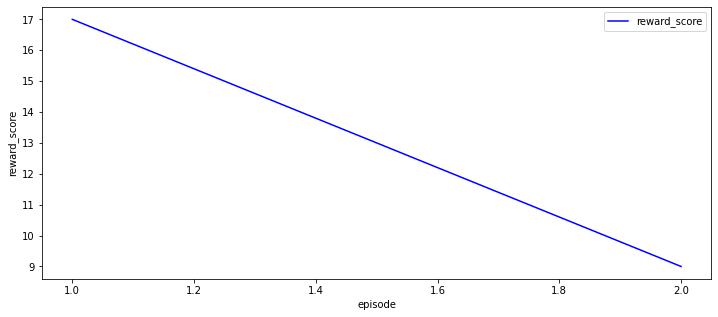

In [29]:
%matplotlib inline
import pandas as pd
import json

training_metrics_file = "training_metrics.json"
training_metrics_path = "{}/{}".format(s3_prefix, training_metrics_file)
wait_for_s3_object(s3_bucket, training_metrics_path, tmp_dir)

json_file = "{}/{}".format(tmp_dir, training_metrics_file)
with open(json_file) as fp:
    data = json.load(fp)

df = pd.DataFrame(data["metrics"])
x_axis = "episode"
y_axis = "reward_score"

plt = df.plot(x=x_axis, y=y_axis, figsize=(12, 5), legend=True, style="b-")
plt.set_ylabel(y_axis)
plt.set_xlabel(x_axis);

### Clean up RoboMaker and SageMaker training job

Execute the cells below if you want to kill RoboMaker and SageMaker job.

In [ ]:
# # Cancelling robomaker job
# for job_arn in job_arns:
#     robomaker.cancel_simulation_job(job=job_arn)

# # Stopping sagemaker training job
# sage_session.sagemaker_client.stop_training_job(TrainingJobName=estimator._current_job_name)

# Evaluation (Time trail, Object avoidance, Head to bot)

In [ ]:
s3_yaml_name = "evaluation_params.yaml"
world_name = "reInvent2019_track"

with open("./src/artifacts/yaml/evaluation_yaml_template.yaml", "r") as filepointer:
    yaml_config = yaml.load(filepointer)

yaml_config["WORLD_NAME"] = world_name
yaml_config["MODEL_S3_BUCKET"] = s3_bucket
yaml_config["MODEL_S3_PREFIX"] = s3_prefix
yaml_config["AWS_REGION"] = aws_region
yaml_config["METRICS_S3_BUCKET"] = s3_bucket
yaml_config["METRICS_S3_OBJECT_KEY"] = "{}/evaluation_metrics.json".format(s3_prefix)
yaml_config["SIMTRACE_S3_BUCKET"] = s3_bucket
yaml_config["SIMTRACE_S3_PREFIX"] = "{}/iteration-data/evaluation".format(s3_prefix)
yaml_config["ROBOMAKER_SIMULATION_JOB_ACCOUNT_ID"] = account_id
yaml_config["NUMBER_OF_TRIALS"] = "5"
yaml_config["MP4_S3_BUCKET"] = s3_bucket
yaml_config["MP4_S3_OBJECT_PREFIX"] = "{}/iteration-data/evaluation".format(s3_prefix)

# Race-type supported for training are TIME_TRIAL, OBJECT_AVOIDANCE, HEAD_TO_BOT
# If you need to modify more attributes look at the template yaml file
race_type = "TIME_TRIAL"

if race_type == "OBJECT_AVOIDANCE":
    yaml_config["NUMBER_OF_OBSTACLES"] = "6"
    yaml_config["RACE_TYPE"] = "OBJECT_AVOIDANCE"

elif race_type == "HEAD_TO_BOT":
    yaml_config["NUMBER_OF_BOT_CARS"] = "6"
    yaml_config["RACE_TYPE"] = "HEAD_TO_BOT"

# Printing the modified yaml parameter
for key, value in yaml_config.items():
    print("{}: {}".format(key.ljust(40, " "), value))

# Uploading the modified yaml parameter
with open("./evaluation_params.yaml", "w") as filepointer:
    yaml.dump(yaml_config, filepointer)

!aws s3 cp ./evaluation_params.yaml {s3_location}/evaluation_params.yaml
!rm evaluation_params.yaml

In [ ]:
responses = list()
for job_no in range(num_simulation_workers):
    response = robomaker.create_simulation_job(
        clientRequestToken=strftime("%Y-%m-%d-%H-%M-%S", gmtime()),
        outputLocation={
            "s3Bucket": s3_bucket,
            "s3Prefix": s3_prefix
        },
        maxJobDurationInSeconds=job_duration_in_seconds,
        iamRole=sagemaker_role,
        failureBehavior="Fail",
        simulationApplications=[{
            "application": simulation_app_arn,
            "applicationVersion": "$LATEST",
            "launchConfig": {
                "packageName": "deepracer_simulation_environment",
                "launchFile": "evaluation.launch",
                "environmentVariables": {
                    "S3_YAML_NAME": s3_yaml_name,
                    "MODEL_S3_PREFIX": s3_prefix,
                    "MODEL_S3_BUCKET": s3_bucket,
                    "WORLD_NAME": world_name,
                    "KINESIS_VIDEO_STREAM_NAME": kvs_stream_name,
                    "APP_REGION": aws_region,
                    "MODEL_METADATA_FILE_S3_KEY": "%s/model/model_metadata.json" % s3_prefix,
                },
                "streamUI": True
            },
            "uploadConfigurations": [{
                    "name": "gazebo-logs",
                    "path": "/root/.gazebo/server*/*.log",
                    "uploadBehavior": "UPLOAD_ON_TERMINATE"
                },
                {
                    "name": "ros-logs",
                    "path": "/root/.ros/log/**",
                    "uploadBehavior": "UPLOAD_ON_TERMINATE"
                }
            ],
            "useDefaultUploadConfigurations": False,
            "tools": [{
                "streamUI": True,
                "name": "rviz",
                "command": "source /opt/ros/melodic/setup.bash;source /opt/amazon/install/setup.bash; rviz",
                "streamOutputToCloudWatch": True,
                "exitBehavior": "RESTART"
              },
              {
                "streamUI": True,
                "name": "terminal",
                "command": "source /opt/ros/melodic/setup.bash;source /opt/amazon/install/setup.bash; xfce4-terminal",
                "streamOutputToCloudWatch": True,
                "exitBehavior": "RESTART"
              },
              {
                "streamUI": True,
                "name": "gazebo",
                "command": "source /opt/ml/code/scripts/gzclient_source.sh; export GAZEBO_MODEL_PATH=/opt/amazon/install/deepracer_simulation_environment/share/deepracer_simulation_environment/; gzclient",
                "streamOutputToCloudWatch": True,
                "exitBehavior": "RESTART"
            }],
        }],
        vpcConfig={
            "subnets": deepracer_subnets,
            "securityGroups": deepracer_security_groups,
            "assignPublicIp": True
        }
    )
    responses.append(response)
    time.sleep(5)
    
print("Created the following jobs:")
job_arns = [response["arn"] for response in responses]
for job_arn in job_arns:
    print("Job ARN", job_arn)

### Visualizing the simulations in RoboMaker
You can visit the RoboMaker console to visualize the simulations or run the following cell to generate the hyperlinks.

In [ ]:
display(Markdown(generate_robomaker_links(job_arns, aws_region)))

### Creating temporary folder top plot metrics

In [ ]:
evaluation_metrics_file = "evaluation_metrics.json"
evaluation_metrics_path = "{}/{}".format(s3_prefix, evaluation_metrics_file)
wait_for_s3_object(s3_bucket, evaluation_metrics_path, tmp_dir)

json_file = "{}/{}".format(tmp_dir, evaluation_metrics_file)
with open(json_file) as fp:
    data = json.load(fp)

df = pd.DataFrame(data["metrics"])
# Converting milliseconds to seconds
df["elapsed_time"] = df["elapsed_time_in_milliseconds"] / 1000
df = df[["trial", "completion_percentage", "elapsed_time"]]

display(df)

### Clean Up Simulation Application Resource

In [ ]:
# robomaker.delete_simulation_application(application=simulation_app_arn)

### Clean your S3 bucket (Uncomment the awscli commands if you want to do it)

In [ ]:
## Uncomment if you only want to clean the s3 bucket
# sagemaker_s3_folder = "s3://{}/{}".format(s3_bucket, s3_prefix)
# !aws s3 rm --recursive {sagemaker_s3_folder}

# robomaker_s3_folder = "s3://{}/{}".format(s3_bucket, job_name)
# !aws s3 rm --recursive {robomaker_s3_folder}

# robomaker_sim_app = "s3://{}/{}".format(s3_bucket, 'robomaker')
# !aws s3 rm --recursive {robomaker_sim_app}

# model_output = "s3://{}/{}".format(s3_bucket, s3_bucket)
# !aws s3 rm --recursive {model_output}

# Head-to-head Evaluation

In [ ]:
# S3 bucket
s3_bucket_2 = sage_session.default_bucket()

# Ensure that the S3 prefix contains the keyword 'sagemaker'
# e.g."deepracer-notebook-sagemaker-200422-231836"
# Please provide the second agents s3_prefix
s3_prefix_2 = "[FILL OUT PREFIX]"

if not s3_prefix_2:
    raise Exception(
        "Please provide the second agents s3_prefix and s3_bucket. The prefix would have sagemaker in between"
    )

print("Using s3 bucket {}".format(s3_bucket_2))
print(
    "Model checkpoints and other metadata will be stored at: \ns3://{}/{}".format(
        s3_bucket_2, s3_prefix_2
    )
)

In [ ]:
s3_yaml_name = "evaluation_params.yaml"
world_name = "reInvent2019_track"

with open("./src/artifacts/yaml/head2head_yaml_template.yaml", "r") as filepointer:
    yaml_config = yaml.load(filepointer)

yaml_config["WORLD_NAME"] = world_name
yaml_config["MODEL_S3_BUCKET"] = [s3_bucket, s3_bucket_2]
yaml_config["MODEL_S3_PREFIX"] = [s3_prefix, s3_prefix_2]
yaml_config["MODEL_METADATA_FILE_S3_KEY"] = [
    "{}/model/model_metadata.json".format(s3_prefix),
    "{}/model/model_metadata.json".format(s3_prefix_2),
]
yaml_config["AWS_REGION"] = aws_region
yaml_config["METRICS_S3_BUCKET"] = [s3_bucket, s3_bucket_2]
yaml_config["METRICS_S3_OBJECT_KEY"] = [
    "{}/evaluation_metrics.json".format(s3_prefix),
    "{}/evaluation_metrics.json".format(s3_prefix_2),
]
yaml_config["SIMTRACE_S3_BUCKET"] = [s3_bucket, s3_bucket_2]
yaml_config["SIMTRACE_S3_PREFIX"] = [
    "{}/iteration-data/evaluation".format(s3_prefix),
    "{}/iteration-data/evaluation".format(s3_prefix_2),
]
yaml_config["ROBOMAKER_SIMULATION_JOB_ACCOUNT_ID"] = account_id
yaml_config["NUMBER_OF_TRIALS"] = "5"
yaml_config["MP4_S3_BUCKET"] = [s3_bucket, s3_bucket_2]
yaml_config["MP4_S3_OBJECT_PREFIX"] = [
    "{}/iteration-data/evaluation".format(s3_prefix),
    "{}/iteration-data/evaluation".format(s3_prefix_2),
]

# Race-type supported for training are TIME_TRIAL, OBJECT_AVOIDANCE, HEAD_TO_BOT
# If you need to modify more attributes look at the template yaml file
race_type = "TIME_TRIAL"

if race_type == "OBJECT_AVOIDANCE":
    yaml_config["NUMBER_OF_OBSTACLES"] = "6"
    yaml_config["RACE_TYPE"] = "OBJECT_AVOIDANCE"

elif race_type == "HEAD_TO_BOT":
    yaml_config["NUMBER_OF_BOT_CARS"] = "6"
    yaml_config["RACE_TYPE"] = "HEAD_TO_BOT"

# Printing the modified yaml parameter
for key, value in yaml_config.items():
    print("{}: {}".format(key.ljust(40, " "), value))

# Uploading the modified yaml parameter
with open("./evaluation_params.yaml", "w") as filepointer:
    yaml.dump(yaml_config, filepointer)

!aws s3 cp ./evaluation_params.yaml {s3_location}/evaluation_params.yaml
!rm evaluation_params.yaml

In [ ]:
responses = list()
for job_no in range(num_simulation_workers):
    response = robomaker.create_simulation_job(
        clientRequestToken=strftime("%Y-%m-%d-%H-%M-%S", gmtime()),
        outputLocation={
            "s3Bucket": s3_bucket,
            "s3Prefix": s3_prefix
        },
        maxJobDurationInSeconds=job_duration_in_seconds,
        iamRole=sagemaker_role,
        failureBehavior="Fail",
        simulationApplications=[{
            "application": simulation_app_arn,
            "applicationVersion": "$LATEST",
            "launchConfig": {
                "packageName": "deepracer_simulation_environment",
                "launchFile": "evaluation.launch",
                "environmentVariables": {
                    "S3_YAML_NAME": s3_yaml_name,
                    "MODEL_S3_PREFIX": s3_prefix,
                    "MODEL_S3_BUCKET": s3_bucket,
                    "WORLD_NAME": world_name,
                    "KINESIS_VIDEO_STREAM_NAME": kvs_stream_name,
                    "APP_REGION": aws_region,
                    "MODEL_METADATA_FILE_S3_KEY": "%s/model/model_metadata.json" % s3_prefix,
                },
                "streamUI": True
            },
            "uploadConfigurations": [{
                    "name": "gazebo-logs",
                    "path": "/root/.gazebo/server*/*.log",
                    "uploadBehavior": "UPLOAD_ON_TERMINATE"
                },
                {
                    "name": "ros-logs",
                    "path": "/root/.ros/log/**",
                    "uploadBehavior": "UPLOAD_ON_TERMINATE"
                }
            ],
            "useDefaultUploadConfigurations": False,
            "tools": [{
                "streamUI": True,
                "name": "rviz",
                "command": "source /opt/ros/melodic/setup.bash;source /opt/amazon/install/setup.bash; rviz",
                "streamOutputToCloudWatch": True,
                "exitBehavior": "RESTART"
              },
              {
                "streamUI": True,
                "name": "terminal",
                "command": "source /opt/ros/melodic/setup.bash;source /opt/amazon/install/setup.bash; xfce4-terminal",
                "streamOutputToCloudWatch": True,
                "exitBehavior": "RESTART"
              },
              {
                "streamUI": True,
                "name": "gazebo",
                "command": "source /opt/ml/code/scripts/gzclient_source.sh; export GAZEBO_MODEL_PATH=/opt/amazon/install/deepracer_simulation_environment/share/deepracer_simulation_environment/; gzclient",
                "streamOutputToCloudWatch": True,
                "exitBehavior": "RESTART"
            }],
        }],
        vpcConfig={
            "subnets": deepracer_subnets,
            "securityGroups": deepracer_security_groups,
            "assignPublicIp": True
        }
    )
    responses.append(response)
    time.sleep(5)
    
print("Created the following jobs:")
job_arns = [response["arn"] for response in responses]
for job_arn in job_arns:
    print("Job ARN", job_arn)

### Visualizing the simulations in RoboMaker
You can visit the RoboMaker console to visualize the simulations or run the following cell to generate the hyperlinks.

In [ ]:
display(Markdown(generate_robomaker_links(job_arns, aws_region)))

### Creating temporary folder top plot metrics

In [ ]:
evaluation_metrics_file = "evaluation_metrics.json"
evaluation_metrics_path = "{}/{}".format(s3_prefix, evaluation_metrics_file)
wait_for_s3_object(s3_bucket, evaluation_metrics_path, tmp_dir)

json_file = "{}/{}".format(tmp_dir, evaluation_metrics_file)
with open(json_file) as fp:
    data = json.load(fp)

df_1 = pd.DataFrame(data["metrics"])
# Converting milliseconds to seconds
df_1["elapsed_time"] = df_1["elapsed_time_in_milliseconds"] / 1000
df_1 = df_1[["trial", "completion_percentage", "elapsed_time"]]

display(df_1)

In [ ]:
evaluation_metrics_file = "evaluation_metrics.json"
evaluation_metrics_path = "{}/{}".format(s3_prefix_2, evaluation_metrics_file)
wait_for_s3_object(s3_bucket_2, evaluation_metrics_path, tmp_dir)

json_file = "{}/{}".format(tmp_dir, evaluation_metrics_file)
with open(json_file) as fp:
    data = json.load(fp)

df_2 = pd.DataFrame(data["metrics"])
# Converting milliseconds to seconds
df_2["elapsed_time"] = df_2["elapsed_time_in_milliseconds"] / 1000
df_2 = df_2[["trial", "completion_percentage", "elapsed_time"]]

display(df_2)